In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from scipy.stats import pearsonr, ttest_ind
from sklearn.preprocessing import MinMaxScaler


In [2]:
mdata = pd.read_csv("mdata.csv")

In [3]:
mdata

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chips compny seasalt175g,2,6.0,175.0,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese 175g,3,6.3,175.0,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,170.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chips thinly s/cream&onion 175g,5,15.0,175.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili 150g,3,13.8,150.0,KETTLE,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream 175g,2,10.8,175.0,KETTLE,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,tostitos splash of lime 175g,1,4.4,175.0,TOSTITOS,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,doritos mexicana 170g,2,8.8,170.0,DORITOS,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,doritos corn chips mexican jalapeno 150g,2,7.8,150.0,DORITOS,YOUNG SINGLES/COUPLES,Premium


In [4]:
mdata['DATE'] = pd.to_datetime(mdata['DATE'])
mdata['MONTH']=mdata['DATE'].dt.month

In [5]:
monthly_metrics = mdata.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    total_customers=('LYLTY_CARD_NBR', lambda x: x.nunique()),
    transactions_per_customer=('LYLTY_CARD_NBR', lambda x: x.count()/x.nunique())
).reset_index()



In [6]:
MONTH_ORDER = {7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 1: 7, 2: 8, 3: 9, 4: 10, 5: 11, 6: 12}
monthly_metrics['MONTH_ORDER'] = monthly_metrics['MONTH'].map(MONTH_ORDER)
monthly_metrics = monthly_metrics.sort_values(['STORE_NBR', 'MONTH_ORDER'])
# monthly_metrics = monthly_metrics.drop(columns=['MONTH_ORDER'])
monthly_metrics = monthly_metrics.reset_index(drop=True)

In [7]:
monthly_metrics

,STORE_NBR,MONTH,total_sales,total_customers,transactions_per_customer,MONTH_ORDER
0,1,7,188.9,47,1.042553,1
1,1,8,168.4,41,1.000000,2
2,1,9,268.1,57,1.035088,3
3,1,10,175.4,39,1.025641,4
4,1,11,184.8,44,1.022727,5
...,...,...,...,...,...,...
3160,272,2,385.3,44,1.068182,8
3161,272,3,421.9,48,1.062500,9
3162,272,4,445.1,54,1.037037,10
3163,272,5,314.6,34,1.176471,11


In [8]:
trial_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 77].sort_values('MONTH')
control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 86].sort_values('MONTH')
merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
merged

,STORE_NBR_trial,MONTH,total_sales_trial,total_customers_trial,transactions_per_customer_trial,MONTH_ORDER_trial,STORE_NBR_control,total_sales_control,total_customers_control,transactions_per_customer_control,MONTH_ORDER_control
0,77,1,188.4,31,1.129032,7,86,800.60,89,1.359551,7
1,77,2,211.6,40,1.000000,8,86,872.80,105,1.247619,8
2,77,3,255.1,46,1.108696,9,86,945.40,108,1.185185,9
3,77,4,258.1,47,1.000000,10,86,804.00,99,1.212121,10
4,77,5,272.3,53,1.018868,11,86,826.90,99,1.191919,11
5,77,6,246.6,38,1.026316,12,86,766.00,92,1.195652,12
6,77,7,268.4,47,1.085106,1,86,851.00,94,1.276596,1
7,77,8,247.5,46,1.000000,2,86,726.85,92,1.152174,2
8,77,9,216.8,40,1.050000,3,86,855.00,100,1.210000,3
9,77,10,194.3,36,1.027778,4,86,898.80,105,1.238095,4


In [9]:
def calculate_similarity(trial_store, metric_df):   

    trial_metrics = metric_df[metric_df['STORE_NBR'] == trial_store].sort_values('MONTH')
    # First, collect all differences to normalize across all stores
    all_diffs = []

    for store in metric_df['STORE_NBR'].unique():
        if store == trial_store:
            continue

        control_metrics = metric_df[metric_df['STORE_NBR'] == store].sort_values('MONTH')
        if len(control_metrics) < 12:  # filter to reach stores that are operational for the entire observation period.
            continue

        merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
        merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
        
        # Calculate differences for this store
        diff = abs(merged['total_sales_trial'] - merged['total_sales_control'])
        all_diffs.extend(diff.tolist())



    # Now calculate scores with global normalization

    control_scores = []
    for store in metric_df['STORE_NBR'].unique():
        if store == trial_store:
            continue

        control_metrics = metric_df[metric_df['STORE_NBR'] == store].sort_values('MONTH')
        if len(control_metrics) < 12:
            continue

        merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
        merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
        # Global normalization
        global_min = min(all_diffs)
        global_max = max(all_diffs)

        corr, _ = pearsonr(merged['total_sales_trial'], merged['total_sales_control'])
        corr_score = max(0, corr)   # just positive indicator
        diff = abs(merged['total_sales_trial'] - merged['total_sales_control'])
        mag = 1 - (diff - global_min) / (global_max-global_min)
        mag_score = mag.mean()
        final_score = (1.0*corr_score + 0.0*mag_score)  # positive indicator, the higher the more similar
        control_scores.append((store, final_score))

    best_match1 = sorted(control_scores, key=lambda x: x[1], reverse=True)[0]
    return best_match1


the code bellow is just inside of the function above for testing the results:

In [10]:
trial_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 77].sort_values('MONTH')
# First, collect all differences to normalize across all stores
all_diffs = []

for store in monthly_metrics['STORE_NBR'].unique():
    if store == 77:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:  # filter to reach stores that are operational for the entire observation period.
        continue

    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    
    # Calculate differences for this store
    diff = abs(merged['total_sales_trial'] - merged['total_sales_control'])
    all_diffs.extend(diff.tolist())



# Now calculate scores with global normalization

control_scores = []
for store in monthly_metrics['STORE_NBR'].unique():
    if store == 77:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:
        continue

    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    # Global normalization
    global_min = min(all_diffs)
    global_max = max(all_diffs)

    corr, _ = pearsonr(merged['total_sales_trial'], merged['total_sales_control'])
    corr_score = max(0, corr)   # just positive indicator
    diff = abs(merged['total_sales_trial'] - merged['total_sales_control'])
    mag = 1 - (diff - global_min) / (global_max-global_min)
    mag_score = mag.mean()
    final_score = (1.0*corr_score + 0.0*mag_score)  # positive indicator, the higher the more similar
    control_scores.append((store, final_score))

best_match1 = sorted(control_scores, key=lambda x: x[1], reverse=True)
best_match1


[(233, 0.9516145370414857),
 (162, 0.8545977400683735),
 (50, 0.7897528147725177),
 (157, 0.7841135386310024),
 (30, 0.7495885312916646),
 (71, 0.7343197313232523),
 (17, 0.6970941117112176),
 (113, 0.694289016734511),
 (35, 0.6926628807806572),
 (105, 0.6847720856821127),
 (60, 0.6745158218437699),
 (234, 0.670972823874774),
 (167, 0.670673397638854),
 (53, 0.6533074663551557),
 (250, 0.6420931521889217),
 (115, 0.6239975590989435),
 (257, 0.6199786201190164),
 (27, 0.6176334124663851),
 (237, 0.6023175891591876),
 (254, 0.6007971215409905),
 (192, 0.5981740656059944),
 (119, 0.573245834863851),
 (121, 0.559270924691925),
 (84, 0.5423050737832139),
 (202, 0.5319201583345193),
 (69, 0.5308943726293087),
 (195, 0.5161281881405223),
 (37, 0.5138950387811363),
 (10, 0.5114138754889074),
 (221, 0.4975020462940145),
 (236, 0.4970499125853733),
 (96, 0.49537869941699825),
 (148, 0.4792070412075226),
 (48, 0.47485241722480875),
 (161, 0.47349553264209504),
 (199, 0.4567368998542089),
 (20, 0.

In [11]:
for store in monthly_metrics['STORE_NBR'].unique():
    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:
        print ([store, len(control_metrics)]);

[11, 2]
[31, 2]
[44, 11]
[76, 1]
[85, 1]
[92, 1]
[117, 10]
[177, 11]
[193, 3]
[206, 2]
[218, 11]
[252, 2]


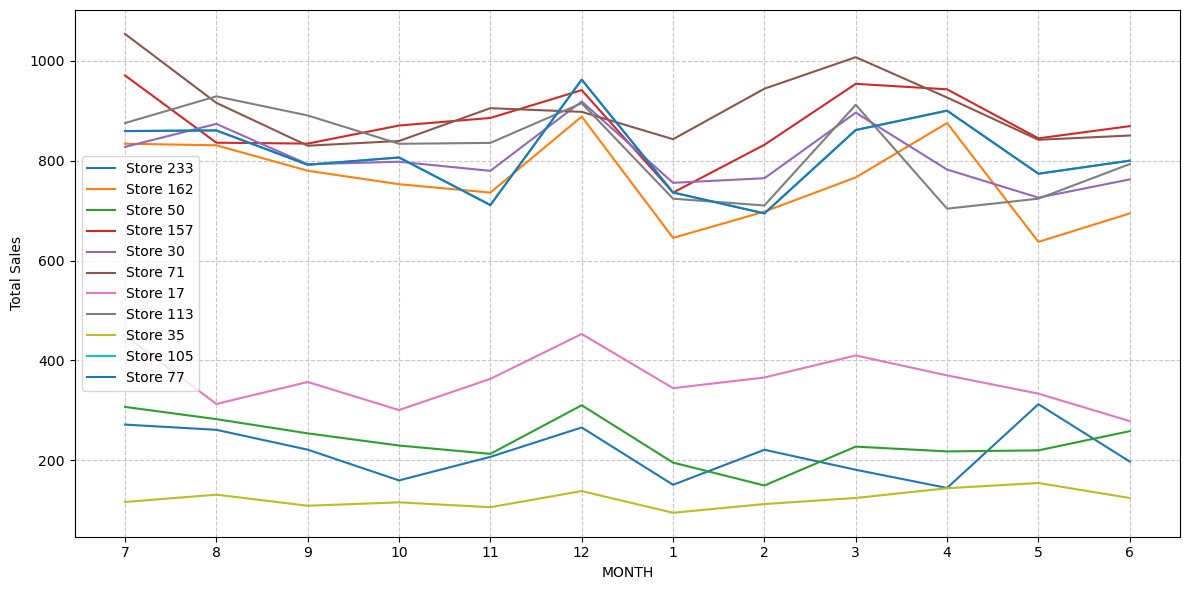

In [12]:
plt.figure(figsize=(12, 6))  # Create a larger figure for better visibility

best_match_dict = dict(best_match1[:10])
for i in best_match_dict.keys():
    # Filter the data for the current store and save it to a variable
    store_data = monthly_metrics[monthly_metrics['STORE_NBR'] == i]
    
    # Plot the total sales for this store
    # This assumes monthly_metrics has a datetime index or a column representing months
    plt.plot(store_data['MONTH_ORDER'], store_data['total_sales'], label=f'Store {i}')
    plt.xticks(store_data['MONTH_ORDER'], store_data['MONTH'])

i = 77
plt.plot(store_data['MONTH_ORDER'], store_data['total_sales'], label=f'Store {i}')

plt.xlabel('MONTH')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the legend
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

### selecting top 10 results from best_match1 and then narrow down to stores within ±25% of the trial store's mean before trial period:

In [18]:
# Get the top 10 stores from best_match
top_10_stores = best_match1[:10]

# Calculate the mean for trial store (store 77)
trial_mean = monthly_metrics[monthly_metrics['STORE_NBR'] == 77]['total_sales'].mean()

# Define the threshold range (±20% of trial mean)
lower_threshold = trial_mean * 0.75  # 20% below
upper_threshold = trial_mean * 1.25  # 20% above

print(f"Trial store (77) mean: {trial_mean:.2f}")
print(f"Threshold range: {lower_threshold:.2f} to {upper_threshold:.2f}")

# Filter top 10 stores to those within the threshold
filtered_stores = []
for store, score in top_10_stores:
    store_mean = monthly_metrics[monthly_metrics['STORE_NBR'] == store]['total_sales'].mean()
    if lower_threshold <= store_mean <= upper_threshold:
        filtered_stores.append((store, score, store_mean))

print('...')
print(filtered_stores)


Trial store (77) mean: 236.60
Threshold range: 177.45 to 295.75
...
[(233, 0.9516145370414857, 215.7583333333333), (50, 0.7897528147725177, 238.32500000000002)]


## T-TEST

Null Hypothesis (H₀): There is no significant difference in the mean number of customers between store #77 and store #233 during the trial period.

In [14]:
trial_period = [2, 3, 4]

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 77) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 233) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

# Compare total sales
t_stat, p_val = ttest_ind(trial_data['total_sales'], control_data['total_sales'])

print(f"Trial Store {77} vs Control Store {233}")
print(f"  T-Stat: {t_stat:.2f}, P-Value: {p_val:.4f}")
print(f"  Trial Mean: {trial_data['total_sales'].mean():.2f}, Control Mean: {control_data['total_sales'].mean():.2f}")
print("---")

merged = pd.merge(trial_data, control_data, on='MONTH', suffixes=('_trial', '_control'))

merged

Trial Store 77 vs Control Store 233
  T-Stat: 2.24, P-Value: 0.0889
  Trial Mean: 241.60, Control Mean: 181.83
---


,STORE_NBR_trial,MONTH,total_sales_trial,total_customers_trial,transactions_per_customer_trial,MONTH_ORDER_trial,STORE_NBR_control,total_sales_control,total_customers_control,transactions_per_customer_control,MONTH_ORDER_control
0,77,2,211.6,40,1.000000,8,233,220.7,42,1.023810,8
1,77,3,255.1,46,1.108696,9,233,180.6,35,1.028571,9
2,77,4,258.1,47,1.000000,10,233,144.2,27,1.074074,10


At 0.1 level, we reject the null hypothesis. Therefor it would suggest that the trial store (#77) had a significantly different amount of sales compared to the control store (#233) during the trial period, which could indicate that any intervention or treatment applied to store #77 had a measurable effect.

We would want to also check time series plot:

## CONFIDENCE INTERVALS

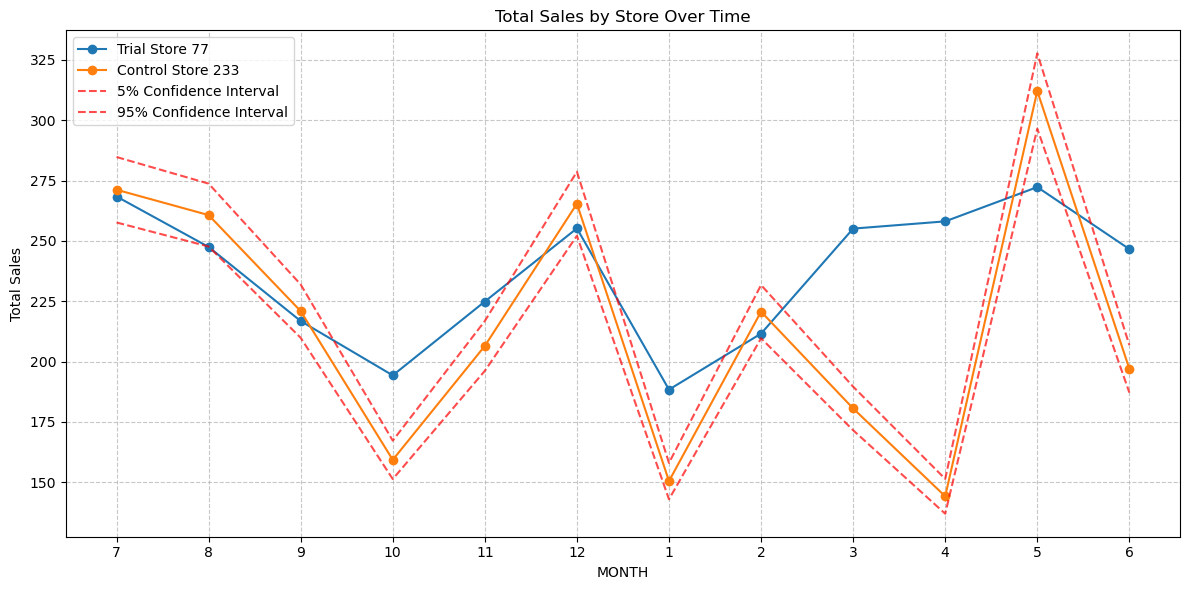

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(12, 6))  

trial_store = 77
control_store = 233

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store)]
plt.plot(trial_data['MONTH_ORDER'], trial_data['total_sales'], label=f'Trial Store {trial_store}', marker='o')


control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store)]
plt.plot(control_data['MONTH_ORDER'], control_data['total_sales'], label=f'Control Store {control_store}', marker='o')


# Calculating simple Confidence Intervals
confidence_level = 0.05
lower_ci = control_data['total_sales'] * (1 - confidence_level)
upper_ci = control_data['total_sales'] * (1 + confidence_level)


plt.plot(control_data['MONTH_ORDER'], lower_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='5% Confidence Interval')
plt.plot(control_data['MONTH_ORDER'], upper_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='95% Confidence Interval')

plt.xticks(trial_data['MONTH_ORDER'], trial_data['MONTH'])
plt.title('Total Sales by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

## Campaign Success Conclusion (control store 233)

Based on our time series analysis along with T-test comparing store 77 with control store 233, we can confidently conclude that the product replacement campaign was successful. The visualization clearly demonstrates a significant surge in sales performance for our trial store during the campaign period that outpaces the control store's trajectory. This differential performance provides evidence that the implemented changes positively impacted customer behavior and store performance.


## we go for the next control store which will be store 50 based on filtered stores that we calculated previously

## T-TEST

Null Hypothesis (H₀): There is no significant difference in the mean number of customers between store #77 and store #233 during the trial period.

In [16]:
trial_period = [2, 3, 4]

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 77) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 50) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

# Compare total sales
t_stat, p_val = ttest_ind(trial_data['total_sales'], control_data['total_sales'])

print(f"Trial Store {77} vs Control Store {50}")
print(f"  T-Stat: {t_stat:.2f}, P-Value: {p_val:.4f}")
print(f"  Trial Mean: {trial_data['total_sales'].mean():.2f}, Control Mean: {control_data['total_sales'].mean():.2f}")
print("---")

Trial Store 77 vs Control Store 50
  T-Stat: 1.52, P-Value: 0.2027
  Trial Mean: 241.60, Control Mean: 197.83
---


Based on the t-test results (T-Stat: 1.52, P-Value: 0.2027), we cannot reject the null hypothesis at 0.1 level significance. Despite the trial store showing a notably higher mean (241.60) compared to the control store (197.83), representing a 22% difference, this variation is not statistically significant. The p-value of 0.2027 indicates there's approximately a 20% probability that this difference could occur by chance. Therefore, while the observed difference may be practically meaningful from a business perspective, we do not have sufficient statistical evidence to conclude that it represents a genuine effect rather than random variation.

Lets check also the visualitics of time series plot:

## CONFIDENCE INTERVALS

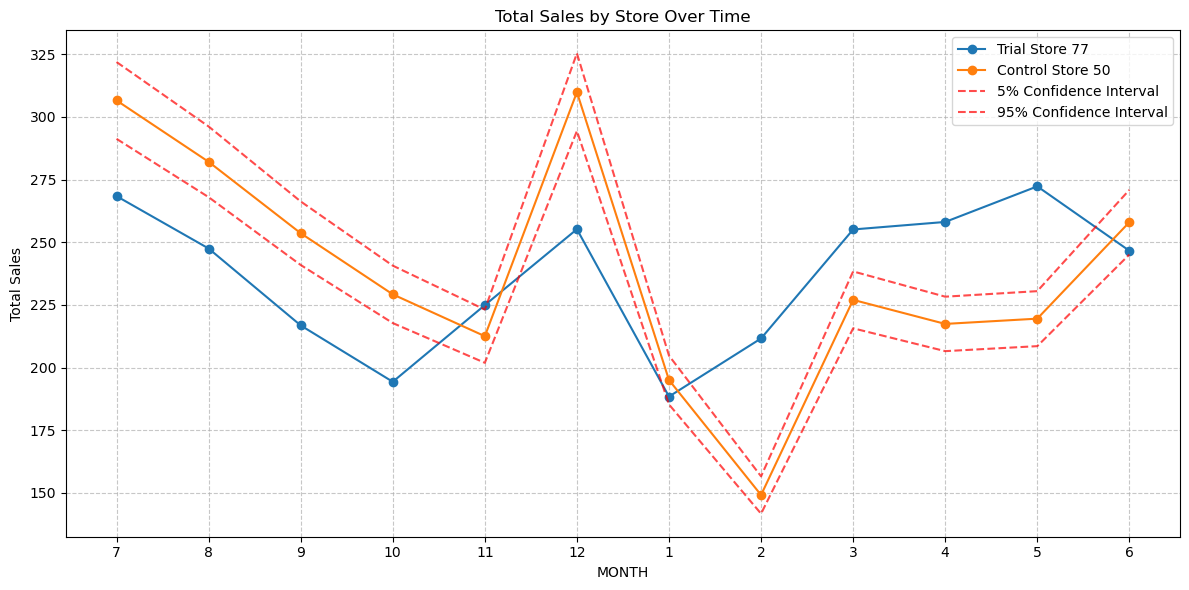

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(12, 6))  

trial_store = 77
control_store = 50

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store)]
plt.plot(trial_data['MONTH_ORDER'], trial_data['total_sales'], label=f'Trial Store {trial_store}', marker='o')


control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store)]
plt.plot(control_data['MONTH_ORDER'], control_data['total_sales'], label=f'Control Store {control_store}', marker='o')


# Calculating simple Confidence Intervals
confidence_level = 0.05
lower_ci = control_data['total_sales'] * (1 - confidence_level)
upper_ci = control_data['total_sales'] * (1 + confidence_level)


plt.plot(control_data['MONTH_ORDER'], lower_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='5% Confidence Interval')
plt.plot(control_data['MONTH_ORDER'], upper_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='95% Confidence Interval')

plt.xticks(trial_data['MONTH_ORDER'], trial_data['MONTH'])
plt.title('Total Sales by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

## Campaign failure Conclusion (control store 50)

We found that both store 50 and 77 showed similar performance surges during the campaign period. The parallel movement in the time series plots indicates that external market factors, not our campaign, likely drove the observed improvements. So based on the T-test and the plot together, we can conclude that the replacement campaign has not been efficient. 

# Final Conclusion on Campaign Effectiveness (Sales amount factor)

Our analysis yields mixed results on the product replacement campaign's impact. Comparison with store 233 shows a distinctive performance advantage for our trial store, suggesting success. However, analysis against store 50 reveals similar performance patterns, indicating broader market influences rather than campaign effects. This inconsistency suggests the campaign likely had a modest positive effect, but its magnitude is difficult to distinguish conclusively from background market fluctuations. Further testing with improved methodology is recommended.
